# Robot Navigation Statistics

This Jupyter notebook contains code which reads in and explores the dataset we discussed in the seminar: navigation data from a mobile robot navigating in an office environment. You should read through the notebook and run each cell in turn. Try to best to understand the code as you run it, since your tasks will require you to alter and resuse it. 

Before going further we'll import some common maths and plotting libraries. If this step fails, please refer to the supporting material you were previously sent.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from datetime import datetime

In this exercise you will work with a comma-separated values (csv) file of data. You should be able to find this file at `../data/tsc_y3_nav_stats.csv`. You should be able to navigate to it in the file browser on the right and open it. Do that first to get an idea of what's in it.

We now need to read the data from the csv file into Python. The code below dies this for you. It uses the built-in csv functionality in Python, combined with file reading. When the file is read in all the values are read in as strings. To allow us to work with the data, we convert the data row-by-row into the native types. The `convert_row` method is specific to the data in this exercise. If you wish to use this approach for subsequent exercises you can copy this code and change the `convert_row` as appropriate.

In [2]:
def read_records(filename):
    """
    Read a CSV file into a list of dictionaries, where each 
    dictionary has keys taken from the column names in the file.
    """
    records = []
    with open(filename, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            convert_row(row)            
            records.append(row)

    return records


def convert_row(row):
    """
    Take a row and convert the values to the known data types.
    """
    #     duration is in seconds
    row['operation_time'] = float(row['operation_time'])
    row['time_to_waypoint'] = float(row['time_to_waypoint'])
    #     dates are converted to datetime objects
    row['date_started'] = datetime.strptime(row['date_started'], '%Y-%m-%d %H:%M:%S')
    row['date_at_node'] = datetime.strptime(row['date_at_node'], '%Y-%m-%d %H:%M:%S')
    row['date_finished'] = datetime.strptime(row['date_finished'], '%Y-%m-%d %H:%M:%S')
    # status of result is converted from a string/integer into a boolean 
    row['status_bin'] = (row['status_bin'] == '1')


Now we use the above code to read in the navigation data from the csv file supplied

In [3]:
data = read_records('../data/tsc_y3_nav_stats.csv')
print('Read in {} records'.format(len(data)))



Read in 12648 records


And we can take a look at the first entry in the data set. We do this by printing the first element of the list `data` which contains all the data we read in.

In [4]:
print(data[0])

{'date_started': datetime.datetime(2016, 5, 23, 18, 45, 47), 'status': 'success', 'origin': 'WayPoint46', 'target': 'WayPoint39', 'final_node': 'WayPoint39', 'edge_id': 'WayPoint46_WayPoint39', 'date_finished': datetime.datetime(2016, 5, 23, 18, 46, 2), 'date_at_node': datetime.datetime(2016, 5, 23, 18, 45, 56), 'operation_time': 14.547985, 'time_to_waypoint': 5.41281, 'status_bin': True}


This shows us the general structure of the data. Each data point is a sample of an attempt to navigate an edge in the robot's topological map. This is indicated by the `edge_id`. The navigation attempt starts from the `origin` node with the aim of reaching `target`. It may successfully reach that node, or it may end up somewhere else. The place it ends up is `final_node`. Each node is a 2D point plus an *influence zone* which is an area around that point. The `operation_time` field indicates the duration (in seconds) of the navigation action until the influence zone is reached. The `time_to_waypoint` is the time spent in the navigation action after the influence zone is reached until the action is terminated. Termination conditions may be the robot reaching the 2D point for the node, being asked to perform a new action which supersedes the current one, or failing (in which case the action is cancelled by another process due to a timeout or another failure condition). These durations can be matched to the dates as follows, `operation_time = date_finished - date_started`, `time_to_waypoint = date_finished - date_at_node` but they were  recorded with sub-second accuracy.

# Data Overview

When working with data, it is important to start by getting a general sense of the nature of that data. We can start by asking how many times each edge was traversed. 

To do this, we will first store the data in a dictionary where they keys are edge ids and the values are lists of data points from the associated edge id. The code below can achieve this grouping for any field in the dataset (i.e. it could do the same for `status_bin` instead of `edge_id`). 

**NOTE**: The code below makes quite heavy use of *dictionaries*. If you do not understand the behaviour of dictionaries in Python, refresh your memory with one of the suggested resources, e.g. https://realpython.com/python-dicts/


In [5]:
def group_data_by_field(datalist, field):
    """
    Given a list of dictionaries, return a dictionary of lists where each sublist contains all dictionaries with the same value of that field, 
    and the key of that entry is that value.
    """
    output = dict()
    for d in datalist:
        # get the value of the field for this entry
        field_value = d[field]
        # if this value has not been seen before, create a new output entry for it
        if field_value not in output:
            output[field_value] = []
        # append the entry to the list for this field value
        output[field_value].append(d)
    return output
        

We now use this function to group the data by `edge_id`, so the result will be a mapping from each `edge_id` to a list of the data entries for that id.

In [6]:
edge_groups = group_data_by_field(data, 'edge_id')

Let's check we're happy with the result by looking at data for some specific edge ids.

In [7]:
edge_groups['WayPoint46_WayPoint39']

[{'date_started': datetime.datetime(2016, 5, 23, 18, 45, 47),
  'status': 'success',
  'origin': 'WayPoint46',
  'target': 'WayPoint39',
  'final_node': 'WayPoint39',
  'edge_id': 'WayPoint46_WayPoint39',
  'date_finished': datetime.datetime(2016, 5, 23, 18, 46, 2),
  'date_at_node': datetime.datetime(2016, 5, 23, 18, 45, 56),
  'operation_time': 14.547985,
  'time_to_waypoint': 5.41281,
  'status_bin': True}]

Above you should see a list with a single entry, and the single entry is a dictionary (i.e. a mapping of keys to values). 

In [8]:
edge_groups['SuppPrintCopy_SuppLocker6']

[{'date_started': datetime.datetime(2016, 5, 26, 19, 35, 32),
  'status': 'success',
  'origin': 'SuppPrintCopy',
  'target': 'SuppLocker6',
  'final_node': 'SuppLocker6',
  'edge_id': 'SuppPrintCopy_SuppLocker6',
  'date_finished': datetime.datetime(2016, 5, 26, 19, 35, 46),
  'date_at_node': datetime.datetime(2016, 5, 26, 19, 35, 46),
  'operation_time': 13.637219,
  'time_to_waypoint': 0.136085,
  'status_bin': True},
 {'date_started': datetime.datetime(2016, 5, 31, 8, 34, 26),
  'status': 'success',
  'origin': 'SuppPrintCopy',
  'target': 'SuppLocker6',
  'final_node': 'SuppLocker6',
  'edge_id': 'SuppPrintCopy_SuppLocker6',
  'date_finished': datetime.datetime(2016, 5, 31, 8, 34, 39),
  'date_at_node': datetime.datetime(2016, 5, 31, 8, 34, 39),
  'operation_time': 13.290232,
  'time_to_waypoint': 0.115745,
  'status_bin': True},
 {'date_started': datetime.datetime(2016, 5, 31, 9, 0, 15),
  'status': 'success',
  'origin': 'SuppPrintCopy',
  'target': 'SuppLocker6',
  'final_node'

Above this you should see a list with three entries, e.g. of the entires is a separate dictionary.

Let's now count now many nav stats (i.e. data points) we have for each edge. We'll do this by creating a new dictionary that maps from edge ids to counts. Before looking at the code below feel free to attempt this yourself, or at least consider how you would need to implement it.


In [9]:
# create an empty dictionary
edge_counts = dict()
# for each edge_id and list of dictionaries in our data set
for edge_id, stat_list in edge_groups.items():
    # map the edge_id to the number of items in the stat list
    edge_counts[edge_id] = len(stat_list)    

We can also write the same code in one line using a *dictionary comprehension* as follows

In [10]:
edge_counts = {edge_id: len(stat_list) for edge_id, stat_list in edge_groups.items()}

The resulting dictionary `edge_counts` allows us to query the data for the number of data points per edge, e.g.

In [11]:
edge_id = 'SuppPrintCopy_SuppLocker6'
print(f"Edge {edge_id} has {edge_counts[edge_id]} entries")

Edge SuppPrintCopy_SuppLocker6 has 3 entries


More usefully, we can visualise the count data as a histogram. To do this we'll need matched lists of edge IDs and counts. 

In [12]:
edge_ids = list(edge_counts.keys())
counts  = list(edge_counts.values())

<BarContainer object of 450 artists>

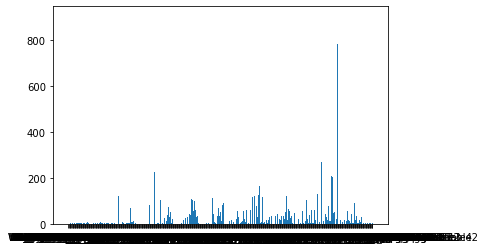

In [13]:
plt.bar(edge_ids, counts)

That's a bit ugly. To make it easier to extract information from, let's start by sorting the data. First we produce a list of (edge_id, count) tuples, then we sort that list. We can verify that this has worked as expected by printing the first and lest element of the list.

In [14]:
# create a list of (edge_id, count) tuples
edge_count_list = [(edge_id, len(stat_list)) for edge_id, stat_list in edge_groups.items()]

# sort the list - `key=lambda x:x[1]` says to sort using the second item of each tuple for comparison.
edge_count_list.sort(key=lambda x:x[1], reverse=True)

# print out the first and last place items from the sorted list
print(edge_count_list[0], edge_count_list[-1])


('SuppLocker13_SuppLocker14', 901) ('NarrowGlass2_CorpTransWP3', 1)


To create the histogram we need matched lists of edge_ids and counts. To create this we extract the first element of every tuple into a list of edge ids, and a the second elements into the count list.

In [15]:
edge_ids = []
counts = []
for tupl in edge_count_list:
    edge_ids.append(tupl[0])
    counts.append(tupl[1])

We can now produce a histogram chart that looks a bit cleaner. We'll also remove the labels from the x axis, which are impossible to read anyway.

/var/folders/2r/32c_88251s5_lt_bfbr7c7gw0000gn/T/ipykernel_4310/1980065644.py:2: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


Text(0.5, 1.0, 'Edge data counts')

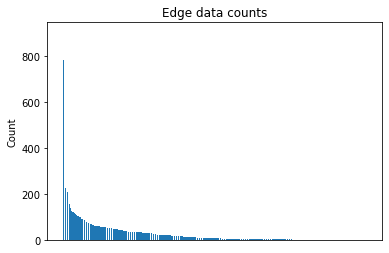

In [16]:
plt.bar(edge_ids, counts)
plt.xticks([])
plt.ylabel('Count')
plt.title('Edge data counts')

There are clearly some interesting edges which have significantly more visits than the the others. Let's look at the top 10.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

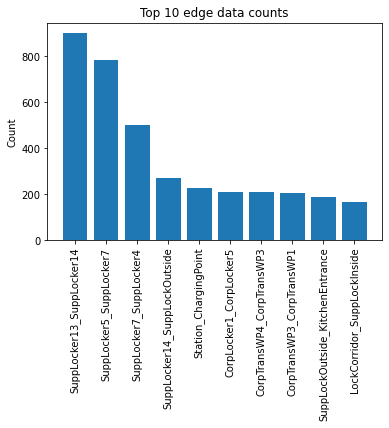

In [17]:
# first 10 edge ids
top_edge_ids = edge_ids[:10]
# first 10 counts
top_counts = counts[:10]
plt.bar(top_edge_ids, top_counts)

plt.ylabel('Count')
plt.title('Top 10 edge data counts')
plt.xticks(rotation=90)

## Tasks

Make sure you follow what the code above is doing. Once you are happy with the provided code, write your own code to complete as many of the following tasks as you want. You may use external libraries (e.g. numpy, scipy) if you wish. Although you can use the empty cells below this one to contain your solutions, you may find it easier to structure your work if you create a new notebook and copy across the the relevant parts of this one.



1. Print out the edges with the maximum and minimum number of visits.
1. Plot a histogram with the 20 fewest datapoints.
1. Determine the mean, median, and mode number of nav stats per edge.
1. Adapt the histograph above so that each bar has a green part for the count of successful navigation actions, and a red part for a count of the unsuccessful ones. You can use the `status_bin` field for this.



# Task 1

## Task 2

## Task 3

## Task 4



# Parameter Estimation for Edge Actions

When we are using this navigation data to build a Markov decision process to plan robot navigation routes, we are interested in two properties of this data: the duration of the navigation action, and whether the action is likely to succeed or not. We can now move on to looking at these features of each edge. 


To start with we'll build a list of (operation_time, date_started, operation_succeeded) tuples for every action on each edge. This will allow us to consider that data together more easily later.

In [18]:
edge_operation_data = dict()

for edge_id, rows in edge_groups.items():    
    edge_operation_data[edge_id] = [(r['operation_time'], r['date_started'], r['status_bin']) for r in rows]
    

Next, let's choose an edge to focus on for some analysis. Focussing on one part of your dataset can allow you get a better handle on your dataset, but be careful not to make unwarranted generalisations to other parts. In this case we're going to focus on one of the edges with lots of data, 'SuppLockOutside_KitchenEntrance'.

In [19]:
focus_edge = 'SuppLockOutside_KitchenEntrance'

To get an initial feel for the operation duration data on this edge let's start by looking at few entries, so we understand what we did above.

In [20]:
edge_operation_data[focus_edge][:10]

[(12.872651, datetime.datetime(2016, 6, 1, 14, 2, 7), True),
 (13.23865, datetime.datetime(2016, 6, 2, 18, 49, 20), True),
 (12.048442, datetime.datetime(2016, 6, 3, 15, 12, 2), True),
 (14.636897, datetime.datetime(2016, 6, 6, 10, 43, 23), True),
 (15.452103, datetime.datetime(2016, 6, 8, 12, 51, 18), True),
 (12.292518, datetime.datetime(2016, 6, 10, 16, 33, 51), True),
 (12.342339, datetime.datetime(2016, 6, 13, 10, 1, 13), True),
 (15.646158, datetime.datetime(2016, 6, 13, 16, 37, 20), True),
 (13.09006, datetime.datetime(2016, 6, 8, 14, 10, 38), True),
 (14.59479, datetime.datetime(2016, 6, 10, 14, 35, 34), True)]

Above you should see tuples of operation time, date, and status for the first 10 entries for the edge we decided to focus on.



## Success Probability

### Single Edge

Complete the function below to estimate the success probability for a single edge. The input should be a list of data tuples for that edge, as printed out above. You should treat the robot attempting to the drive on the edge as a Bernoulli trial and use the parater estimation technique we saw in the first lecture. 

In [21]:
def estimate_success_probability(edge_data): 
    # Replace this with your code
    return 0


In [22]:
print(f"The success probabilty for edge {focus_edge} is estimated to be {estimate_success_probability(edge_operation_data[focus_edge])}")

The success probabilty for edge SuppLockOutside_KitchenEntrance is estimated to be 0


If you have implemented this correctly, you should see that the success probability for the chosen edge is 0.91 (to 2 sf). 

### Multiple Edges

Implement code which uses `estimate_success_probability` to 
1. Estimate the success probability for every edge in the dataset
2. Report the edges with the highest and lowest success probabilities. Note that multiple edges can have the same probability estimate.
3. Plot a histogram of the success probabilities over the whole dataset.

Below we provide empty cells to correspond to these steps, but you can structure your solution however you prefer (i.e. you can use these cells, add your own, or do it all in a single cell... although the latter is bad practice since it limits resuability).


1. Estimate the success probability for every edge in the dataset

To allow you to reuse the results in subsequent steps store the results as a list of (edge_id, success probability) tuples.


In [24]:
edge_id_probs = []
for edge_id, edge_data in edge_operation_data.items():
    # edit the line below to store the requested data in each tuple
    edge_tuple = ()
    edge_id_probs.append(edge_tuple)

2. Report the edges with the highest and lowest success probabilities. Note that multiple edges can have the same probability estimate.

If you need help in doing this, look back to the code above where we examined the number of data points per edge.

3. Plot a histogram of the success probabilities over the whole dataset.

Does the data show you anything unexpected?


## Edge Duration

Now we are going to look at the duration data (`operation_time`) per edge. 

We will assume that the duration of action per edge is normally distributed. This is not an ideal model in practice, but will suffice for this exercise. Consider why it may not be a good distribution for action durations.


### Single Edge Estimation

Once again focussing on a single edge (`focus_edge`), write a function that estimates the mean and variance parameters of a normal distribution based on the durations of this edge. You can either implemented the formulae we proved in the first session or use a function from a library. If you use a library function, be careful to check the return values.

In [34]:
def estimate_duration_parameters(edge_data):
    # Replace this with your code
    mu = 0
    var = 1
    return mu, var


In [35]:
print(f"The duration parameters for edge {focus_edge} is estimated to be {estimate_duration_parameters(edge_operation_data[focus_edge])}")

The duration parameters for edge SuppLockOutside_KitchenEntrance is estimated to be (0, 1)


If correct, your code should return at mean value of 18.09s (to 2 dp), and a variance of 142.43 (to 2 dp). That variance corresponds to standard deviation of roughly 12. Given the mean is around 18, this makes it look as if we might have some quite widely distributed data.

### Single Edge PDF and Visualisation

Lets have a look at the edge data more closely. The code below plots a histogram of durations. When we use the `density=True` argument we convert the histogram into a probability density function. This will allow us to later compare it to the likelihood function of a normal distribution.



(array([0.02179854, 0.04780381, 0.00114729, 0.        , 0.00038243,
        0.00038243, 0.        , 0.        , 0.        , 0.00038243]),
 array([  0.337761 ,  14.2465607,  28.1553604,  42.0641601,  55.9729598,
         69.8817595,  83.7905592,  97.6993589, 111.6081586, 125.5169583,
        139.425758 ]),
 <BarContainer object of 10 artists>)

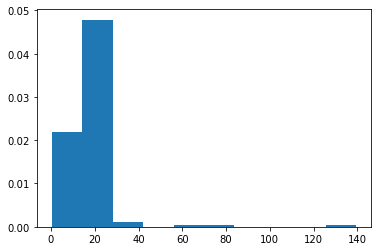

In [36]:
edge_durations = [edge[0] for edge in edge_operation_data[focus_edge]]
plt.hist(edge_durations, density=True)

Let's see how that plot matches up to the normal distribution we've estimated. Do do this, we'll need to compute the *probability density value* (pdf) of a normal distribution for a given value of x. Complete the function below to do this, again using either the formula from the first session or a library function

In [37]:
def norm_pdf(x, mu, var):
    # Your code here
    return 0

With that method we can plot the normal curve on top of the histogram. Note that if you haven't implemented `norm_pdf` yet you should only see a flat orange line for the pdf curve.

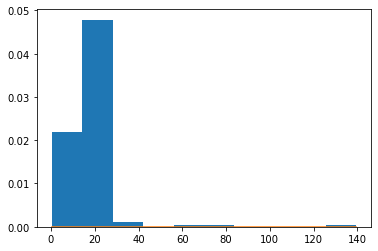

In [40]:
mu, var = estimate_duration_parameters(edge_operation_data[focus_edge])
# create our x values
x = np.linspace(np.min(edge_durations), np.max(edge_durations), 1000)
# use our pdf function to compute a y value for each x
y = [norm_pdf(x_i, mu, var) for x_i in x]
# then plot both
plt.hist(edge_durations, density=True)
plt.plot(x, y)

The curve looks quite well matched to the histogram, but the the high variance is in part due to those high duration values on the right of the plot.

### Single Edge - IID

For maximum likelihood estimation to return the correct result, the values in the dataset should be independent and identically distributed (the IID assumption). So far we have ignored that assumption. However, our dataset contains extra information we can use to test the assumption. In particular, whether or not the edge action succeeded is likely to play a significant role in the duration of the action. Let's explore that idea further. 

In the cell below create two lists of duration values for the focus edge. One list should contain durations of edges actions which succeeded, the other list should contain durations from failures. Plot values from both lists on the same histogram.

In [48]:
# Fill these lists with the requested duration data
edge_success_durations = []
edge_fail_durations = []

print(len(edge_success_durations), len(edge_fail_durations))

if len(edge_success_durations) > 0:
    plt.hist(edge_success_durations, density=True)
    
if len(edge_fail_durations) > 0:
    plt.hist(edge_fail_durations, density=True)

0 0


As a check, you should have 172 duration values in your success list and 16 in your fail list.

You should also see that the duration distribution of successful actions looks pretty different to the distribution of failed actions. 

Let's use this observation and fit separate normal distributions to each list and add those to the plot. 

0 1 0 1


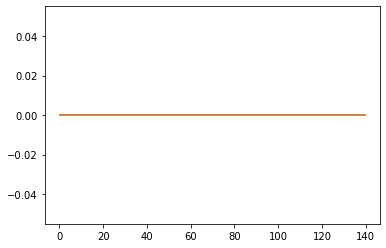

In [49]:
# Replace this with code to esimate success (*_s) and failure (*_f) parameters separately
mu_s, var_s = 0, 1
mu_f, var_f = 0, 1

y_s = [norm_pdf(x_i, mu_s, var_s) for x_i in x]
y_f = [norm_pdf(x_i, mu_f, var_f) for x_i in x]

if len(edge_success_durations) > 0:
    plt.hist(edge_success_durations, density=True)
    
if len(edge_fail_durations) > 0:
    plt.hist(edge_fail_durations, density=True)
    
plt.plot(x, y_s)
plt.plot(x, y_f)

print(mu_s, var_s, mu_f, var_f)



This certainly looks as if the duration distributions for success and failure are goverened by different distributions. In particular the variance of the failure duration distribution is a lot higher than for successes. This makes sense: successes should largely be predictable since they happen when the robot is free to navigate; failures can be due to many different causesm each of which may produce a different delay. In fact, it may be the case that the different failure cases should be modelled separately, but that's beyond the scope of this exericse.

### Multiple Edges

Use everything you have written above to determine:
1. the edge with the lowest expectated duration for a successful execution
2. the edge with the most uncertain duration distribution for failure 

You should find that KitchenPod2_KitchenActRec2 has the lowest expected success duration, around 5.09s.


You should find that the  fail duration with the highest variance is Station1_ChargingPoint1 with 2470.17.


### Multiple Edges - Extension

_This is an optional extension that you should only consider if you have spare time and have completed everything above._

It is common practice in data science to filter out outliers from the data. For example, any value that falls a certain number of standard deviations from the mean could be considered an outlier. Repeat the single edge processing above, but remove outliers that fall more than 3 standard deviations away from the mean of the appropriate distribution.
